# Overview 
THe purpose of this notebook is to prepare the data for modeling.

### Changes
    -Adds a new classifier columns, in addition to the already existing SepsisLabel (1 if Sepsis, 0 if not)
        -Pre_Sepsis_Three (2 States): 1 if in 3 hour period before pre-sepsis onset, 0 otherwise
    -Modifies Vital Signs 
        -Interploate missing values by patient, bfill if first value is missing for patient
        -No values available whatsoever for that patient and feature, then group median for that vital sign used.
    -Adds columns for changes in vitals 
        -Change since previous, two previous and three previous
        -Have prefix d1_, d2_, d3_
    -Modifies Lab Values:
        -Log transforms skewed distributions
        -Forward fill lab values per patient
        -When no lab values exist whatsoever for patient, fill with median.
    -Creates dummy variable columns indicating if lab value is present or not for patient 
        -1 from when the lab value occurs until the end of that patient's data
        -Have prefix dummy_
    -Saves Data
    

# Code Navigation
* [1. Import Libraries & Data](#1.ImportLibraries&Data)
* [2. Add New Classifier Columns](#2.AddNewClassifierColumns)
* [3. Vital Signs](#3.VitalSigns)
    * [3.1. Interpolate & Fill w/ Median](#3.1.Interpolate&Fillw/Median)
    * [3.2. Add Changes in Vital Columns](#3.2.AddChangesinVitalColumns)
* [4. Lab Values](#4.LabValues)
    * [4.1. Log Transform](#4.1.LogTransform)
    * [4.2. Add Lab Indicator Column (Dummy)](#4.2.AddLabIndicatorColumn(Dummy))
* [5. Save Data](#5.SaveData)

## 1. Import Libraries & Data <a class="anchor" id="1.ImportLibraries&Data"></a>

In [1]:
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
os.chdir("../data/interim")

In [3]:
#Load in Data
#First, the notes
with open("Data_Notes.json", "r") as infile:  
    notes=json.load(infile)

#Next, the actual data
df=pd.read_csv('sepsis_data_postEDA.csv',index_col=0)

C:\Users\amcas\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2. Add New Classifier Columns <a class="anchor" id="2.AddNewClassifierColumns"></a>

In [4]:
df.drop(columns=['SepsisClassifier'],inplace=True)

In [5]:
#Create Sepsis Hour Variable 
Group=df[['id','SepsisOnset']]

In [6]:
df_id_class=df[['id','SepsisLabel','SepsisOnset']].copy()

In [7]:
#Sep, No Sep, #Hrs Out (1-6) 
q=0
col_zer=[0 for i in range(len(df))]
for i in range(len(df.id.unique())):
    if df_id_class.loc[df_id_class.id==i]['SepsisLabel'].sum()>1:
        a=df_id_class.loc[df_id_class.id==i]['SepsisOnset'].idxmax()
        r=1
        t=a-1
        y=0
        while y<9:
            if df['id'].iloc[a] == df['id'].iloc[t]:
                col_zer[a-r]=r+1
                r=r+1
                t=t-1
                y=y+1
            else:
                 y=y+1
t=np.array(col_zer)
col_sep_a=df.SepsisLabel.values
col_hrs_out=t+col_sep_a
np.unique(col_hrs_out,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([1503951,   27916,    2501,    2425,    2358,    2312,    2259,
           2194,    2149,    2099,    2046], dtype=int64))

In [8]:
Hourly_Sep=pd.DataFrame(col_hrs_out.reshape(-1,1)[:,0],columns=['Hrs'])

#3hrs_pre_sepsis (1), Everything Else (0)
acute={ 0:0,  1:0,  2:1,  3:1,  4:1,  5:0, 6:0,  7:0,  8:0,  9:0, 10:0}
df['Pre_Sepsis_Three']=Hourly_Sep.Hrs.map(acute)

## 3. Vital Signs <a class="anchor" id="3.VitalSigns"></a>

### 3.1. Interpolate & Fill w/ Median <a class="anchor" id="3.1.Interpolate&Fillw/Median"></a>

In [9]:
#Print out null value counts for each column
pd.DataFrame(df.isnull().sum().sort_values()).head(20)

,0
Pre_Sepsis_Three,0
HospitalA,0
id,0
SepsisLabel,0
ICULOS,0
Unit2,0
Unit1,0
Gender,0
Age,0
SepsisOnset,0


In [10]:
#Interpolate/Fill na for vital sign data

#The interpolate function, combined with groupby as below, won't steal values from other groups. If the missing value 
#is at the end of a subject's time course, the last known value is used. If the missing value is at the start, 
#the interpolate function gives NaN. So, for these instances, I have also added a fillna() call with backfill as an argument.
#Still, there are NaNs left. What I want to do is fill them with the average for that subject, but its proving difficult...
for feature in list(df.loc[:,'HR':'EtCO2'].columns):
    df[feature]=df.groupby('id')[feature].apply(lambda group: group.interpolate())
    df[feature]=df.groupby('id')[feature].fillna(method='bfill')
    df[feature]=df.groupby('id')[feature].transform(lambda x: x.fillna(x.mean()))
    #This doesn't actually do anything - there are still nans left because some patients don't have any values for any of
    #These vital signs. Will replace with the median of the entire data set for that feature. 
    df[feature].fillna(value=df[feature].median(axis=0),inplace=True)

In [11]:
#Print out updated null value counts for each column (vital signs now have 0).
pd.DataFrame(df.isnull().sum().sort_values()).head(20)

,0
HR,0
HospitalA,0
id,0
SepsisLabel,0
ICULOS,0
Unit2,0
Unit1,0
Gender,0
Age,0
SepsisOnset,0


In [12]:
#Ensure that distributions look ok
df.loc[:,'HR':'EtCO2'].describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2
count,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,8.439701e+01,9.715730e+01,3.686037e+01,1.237398e+02,8.272740e+01,6.384218e+01,1.865471e+01,3.307038e+01
std,1.734656e+01,3.079375e+00,6.930944e-01,2.310314e+01,1.626703e+01,1.272019e+01,5.101161e+00,3.866411e+00
min,2.000000e+01,2.000000e+01,3.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,1.000000e+01
25%,7.200000e+01,9.600000e+01,3.642500e+01,1.070000e+02,7.100000e+01,5.600000e+01,1.550000e+01,3.300000e+01
50%,8.300000e+01,9.800000e+01,3.682000e+01,1.210000e+02,8.100000e+01,6.250000e+01,1.800000e+01,3.300000e+01
75%,9.500000e+01,9.900000e+01,3.729250e+01,1.380000e+02,9.200000e+01,7.000000e+01,2.100000e+01,3.300000e+01
max,2.800000e+02,1.000000e+02,4.222000e+01,2.990000e+02,3.000000e+02,3.000000e+02,1.000000e+02,1.000000e+02


### 3.2. Add Changes in Vital Columns <a class="anchor" id="3.2.AddChangesinVitalColumns"></a>

In [13]:
#Add Columns for changes in vitals from last hour
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff()).fillna(value=0).add_prefix('d1_')
df=pd.concat([c,df],axis=1)

In [14]:
#Add Columns for changes in vitals from two hours past
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff(periods=2)).fillna(value=0).add_prefix('d2_')
df=pd.concat([c,df],axis=1)

In [15]:
#Add Columns for changes in vitals from three hours past
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff(periods=3)).fillna(value=0).add_prefix('d3_')
df=pd.concat([c,df],axis=1)

In [16]:
df[0:5]

,d3_HR,d3_O2Sat,d3_Temp,d3_SBP,d3_MAP,d3_DBP,d3_Resp,d3_EtCO2,d2_HR,d2_O2Sat,d2_Temp,d2_SBP,d2_MAP,d2_DBP,d2_Resp,d2_EtCO2,d1_HR,d1_O2Sat,d1_Temp,d1_SBP,d1_MAP,d1_DBP,d1_Resp,d1_EtCO2,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,id,HospitalA,SepsisOnset,Pre_Sepsis_Three
0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,97.0,95.0,36.11,98.0,75.330,62.5,19.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,1,0,0,1,0,0
1,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,97.0,95.0,36.11,98.0,75.330,62.5,19.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,2,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,-8.0,4.0,0.0,24.0,10.670,0.0,3.0,0.0,-8.0,4.0,0.0,24.0,10.670,0.0,3.0,0.0,89.0,99.0,36.11,122.0,86.000,62.5,22.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,3,0,0,1,0,0
3,-7.0,0.0,0.0,24.0,13.335,0.0,11.0,0.0,-7.0,0.0,0.0,24.0,13.335,0.0,11.0,0.0,1.0,-4.0,0.0,0.0,2.665,0.0,8.0,0.0,90.0,95.0,36.11,122.0,88.665,62.5,30.0,33.0,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,4,0,0,1,0,0
4,6.0,-6.5,0.0,24.0,16.000,0.0,5.5,0.0,14.0,-10.5,0.0,0.0,5.330,0.0,2.5,0.0,13.0,-6.5,0.0,0.0,2.665,0.0,-5.5,0.0,103.0,88.5,36.11,122.0,91.330,62.5,24.5,33.0,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,5,0,0,1,0,0


## 4. Lab Values <a class="anchor" id="4.LabValues"></a>

### 4.1. Log Transform <a class="anchor" id="4.1.LogTransform"></a>

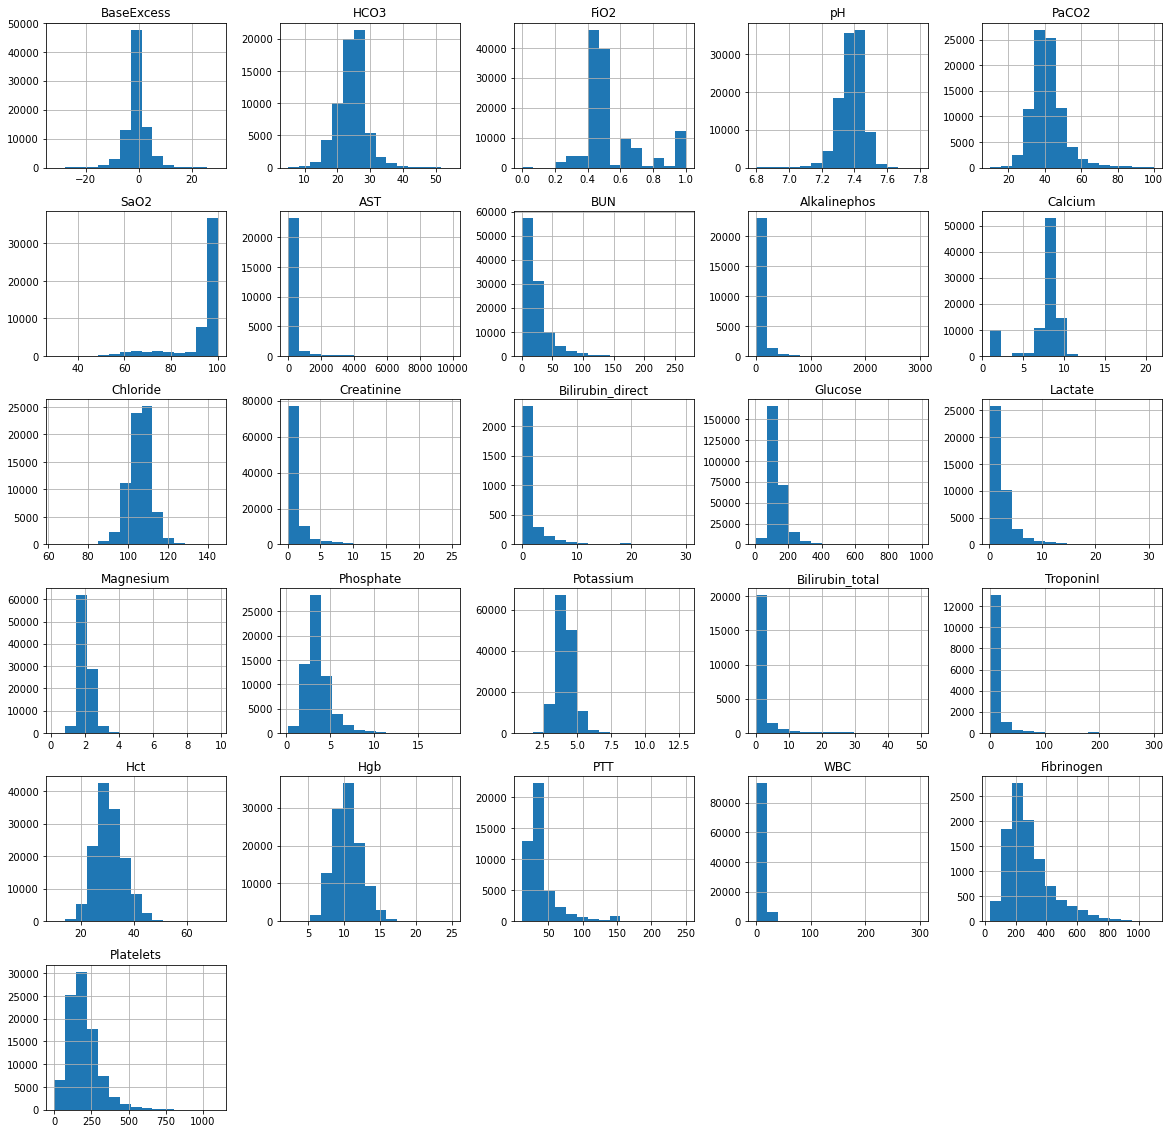

In [17]:
#Plot distributions for lab values
df.loc[:,"BaseExcess":"Platelets"].hist(figsize=(20,20),bins=15)
plt.show()

In [19]:
#Log trasnform the lab values that have skewed distributions
from sklearn.preprocessing import PowerTransformer

#Function to apply log transform to data 
def log_trans_columns(df,list_):
    for feature in list_:
        a=np.array(df[feature]).reshape(-1, 1)
        pow_trans = PowerTransformer()
        q=pow_trans.fit_transform(a)
        df[feature]=q
    return df

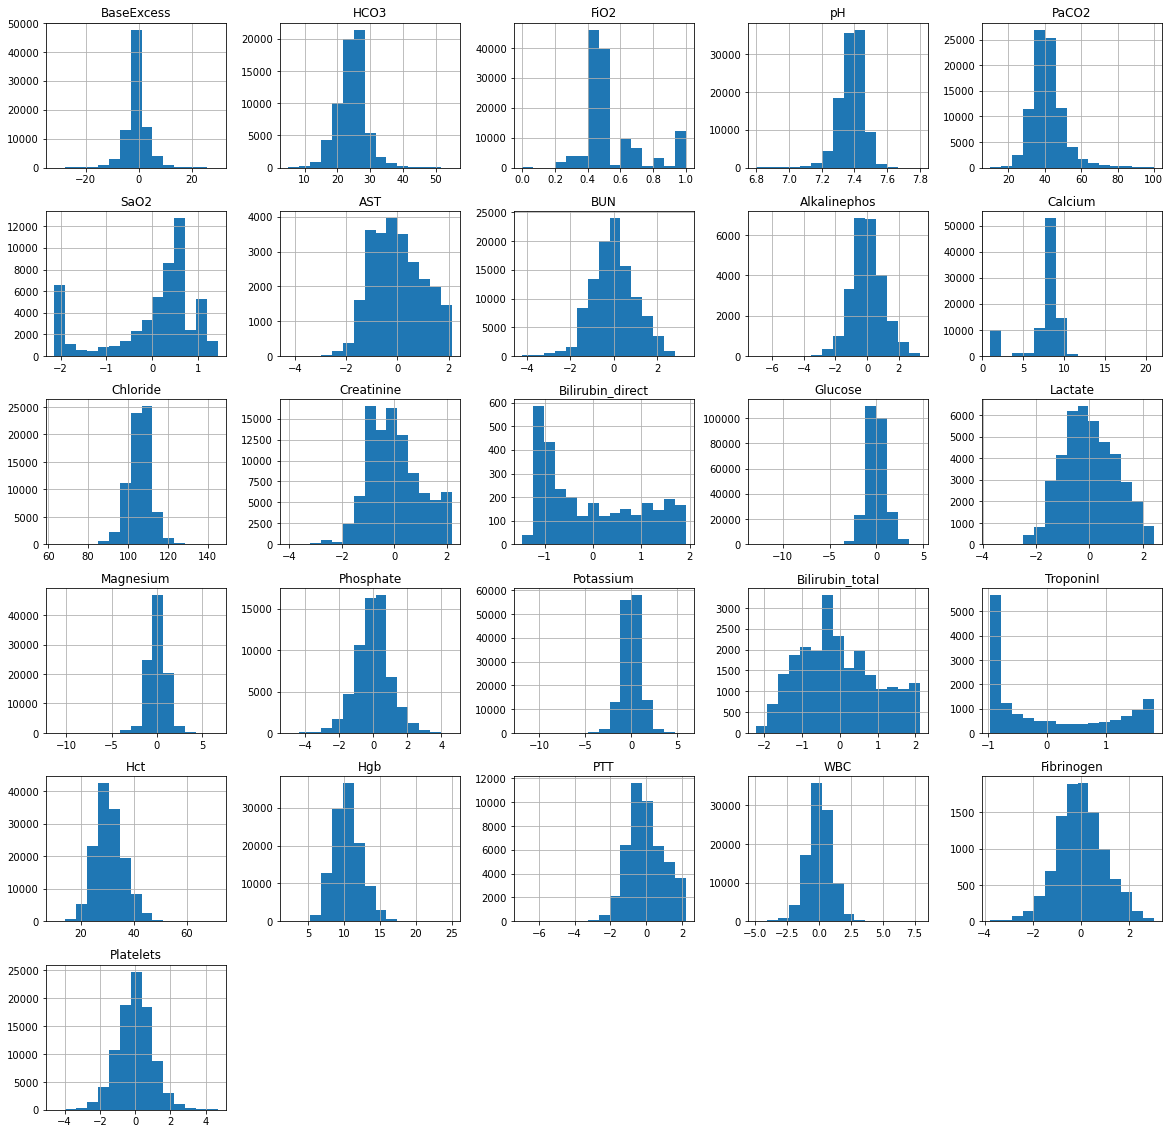

In [20]:
#Lab values with skewed looking distributions
columns=['SaO2','AST', 'BUN','Alkalinephos','Creatinine', 'Bilirubin_direct','Glucose', 'Lactate', \
        'Magnesium','Phosphate', 'Potassium','Bilirubin_total','TroponinI','PTT', 'WBC', \
       'Fibrinogen', 'Platelets']

#Apply transform & plot histogram
df=log_trans_columns(df,columns)
df.loc[:,"BaseExcess":"Platelets"].hist(figsize=(20,20),bins=15)
plt.show()

### 4.2. Add Lab Indicator Column (Dummy) <a class="anchor" id="4.2.AddLabIndicatorColumn(Dummy)"></a>

In [21]:
#Start of code for creating lab indicator value

#Mark entries with a lab value as True
e=df.loc[:,'BaseExcess':'Platelets'].notnull()
df_lab_fill=pd.concat([df.id,e],axis=1)

In [22]:
from datetime import datetime

def lab_dummy(df):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    n=len(df.id.unique())
    s={}
    for feature in list(df.drop(columns='id').columns):
        i=0
        b=[]
        Subset=df[[feature,'id']]
        while i<=n:
            d=Subset.loc[df.id==i][feature].values
            len_=len(d)
            e=[]
            r=[]
            for val in d:
                if val==0:
                    e.append(0)
                    len_=len_-1
                else:
                    r=[1 for i in range(len_)]
                    break
            final=e+r
            b=b+final
            i=i+1
            s['Dum_'+ feature]=b
    return s

In [23]:
dict_=lab_dummy(df_lab_fill)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 11:10:00
Current Time = 12:47:35


In [24]:
#Forward fill missing lab values by patient
df=df.join(pd.DataFrame(dict_))
for feature in list(df.loc[:,'BaseExcess':'Platelets'].columns):
    df[feature]=df.groupby('id')[feature].fillna(method='ffill')
pd.set_option('display.max_rows', 2000)
df[0:20]

,d3_HR,d3_O2Sat,d3_Temp,d3_SBP,d3_MAP,d3_DBP,d3_Resp,d3_EtCO2,d2_HR,d2_O2Sat,d2_Temp,d2_SBP,d2_MAP,d2_DBP,d2_Resp,d2_EtCO2,d1_HR,d1_O2Sat,d1_Temp,d1_SBP,d1_MAP,d1_DBP,d1_Resp,d1_EtCO2,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,id,HospitalA,SepsisOnset,Pre_Sepsis_Three,Dum_BaseExcess,Dum_HCO3,Dum_FiO2,Dum_pH,Dum_PaCO2,Dum_SaO2,Dum_AST,Dum_BUN,Dum_Alkalinephos,Dum_Calcium,Dum_Chloride,Dum_Creatinine,Dum_Bilirubin_direct,Dum_Glucose,Dum_Lactate,Dum_Magnesium,Dum_Phosphate,Dum_Potassium,Dum_Bilirubin_total,Dum_TroponinI,Dum_Hct,Dum_Hgb,Dum_PTT,Dum_WBC,Dum_Fibrinogen,Dum_Platelets
0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,97.0,95.0,36.1100,98.0,75.330,62.5,19.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,97.0,95.0,36.1100,98.0,75.330,62.5,19.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,-8.0,4.0,0.0000,24.0,10.670,0.0,3.0,0.0,-8.0,4.0,0.0000,24.0,10.670,0.0,3.0,0.0,89.0,99.0,36.1100,122.0,86.000,62.5,22.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-7.0,0.0,0.0000,24.0,13.335,0.0,11.0,0.0,-7.0,0.0,0.0000,24.0,13.335,0.0,11.0,0.0,1.0,-4.0,0.0000,0.0,2.665,0.0,8.0,0.0,90.0,95.0,36.1100,122.0,88.665,62.5,30.0,33.0,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,4,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.0,-6.5,0.0000,24.0,16.000,0.0,5.5,0.0,14.0,-10.5,0.0000,0.0,5.330,0.0,2.5,0.0,13.0,-6.5,0.0000,0.0,2.665,0.0,-5.5,0.0,103.0,88.5,36.1100,122.0,91.330,62.5,24.5,33.0,24.0,NaN,0.28,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,5,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,21.0,-8.0,0.0000,0.5,-1.835,0.0,0.0,0.0,20.0,-4.0,0.0000,0.5,-4.500,0.0,-8.0,0.0,7.0,2.5,0.0000,0.5,-7.165,0.0,-2.5,0.0,110.0,91.0,36.1100,122.5,84.165,62.5,22.0,33.0,24.0,NaN,0.28,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,6,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,18.0,-3.0,0.0000,1.0,-11.665,0.0,-1.0,0.0,5.0,3.5,0.0000,1.0,-14.330,0.0,4.5,0.0,-2.0,1.0,0.0000,0.5,-7.165,0.0,7.0,0.0,108.0,92.0,36.1100,123.0,77.000,62.5,29.0,33.0,24.0,NaN,0.28,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,7,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3.0,2.0,0.2650,-29.0,-15.000,0.0,4.5,0.0,-4.0,-0.5,0.2650,-29.5,-7.835,0.0,7.0,0.0,-2.0,-1.5,0.2650,-30.0,-0.670,0.0,0.0,0.0,106.0,90.5,36.3750,93.0,76.330,62.5,29.0,33.0,24.0,NaN,0.28,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,0.0,0.0,-0.03,8,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,-6.0,4.0,0.5300,10.5,4.165,0.0,4.0,0.0,-4.0,3.0,0.5300,10.0,11.330,0.0,-3.0,0.0,-2.0,4.5,0.2650,40.0,12.000,0.0,-3.0,0.0,104.0,95.0,36.6400,133.0,88.330,62.5,26.0,33.0,24.0,NaN,0.28,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0

In [25]:
#Print null value counts - many nulls for lab values
pd.DataFrame(df.isnull().sum().sort_values(ascending=False))

,0
Bilirubin_direct,1479916
Fibrinogen,1385887
TroponinI,1318553
Lactate,1089377
SaO2,1083561
Bilirubin_total,1083290
Alkalinephos,1081750
AST,1077247
BaseExcess,1057124
HCO3,877364


In [26]:
#Replace Remaining Nans with median
df.fillna(df.median(),inplace=True)

In [27]:
#Print out updated null value counts  - will be 0
pd.DataFrame(df.isnull().sum().sort_values())

,0
d3_HR,0
Pre_Sepsis_Three,0
SepsisOnset,0
HospitalA,0
id,0
SepsisLabel,0
ICULOS,0
HospAdmTime,0
Unit2,0
Unit1,0


## 5. Save Data <a class="anchor" id="5.SaveData"></a>

In [28]:
#Save the data 
os.chdir("../processed")
pd.DataFrame.to_csv(df,'sepsis_data_preprocessed.csv')